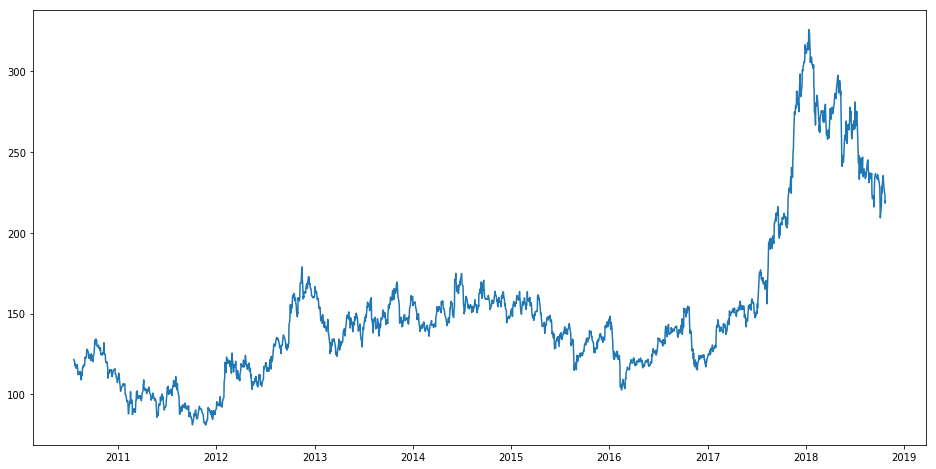

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))

df = pd.read_csv("./data/NSE-TATAGLOBAL.csv")

df['Date'] = pd.to_datetime(df.Date,format = "%Y-%m-%d")
df.index = df['Date']

plt.figure(figsize = (16,8))
plt.plot(df['Close'],label = "Closing Price History")

## Moving Averages

In [2]:
data = df.sort_index(ascending = True, axis = 0)
new_data = pd.DataFrame(index = range(0,len(df)),columns = ['Date','Close'])

In [3]:
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]    

In [4]:
train = new_data[:1803]
valid = new_data[1803:]

In [5]:
train.shape,valid.shape

((1803, 2), (248, 2))

In [6]:
train['Date'].min(), train['Date'].max(), valid['Date'].min(), valid['Date'].max()

(Timestamp('2010-07-21 00:00:00'),
 Timestamp('2017-10-24 00:00:00'),
 Timestamp('2017-10-25 00:00:00'),
 Timestamp('2018-10-24 00:00:00'))

In [7]:
pred = []
for i in range(0,248):
    p = train['Close'][len(train)+i-248:].sum() + sum(pred)
    q = p/248
    pred.append(q)

# RMSE

In [8]:
rmse = np.sqrt(np.mean(np.power((np.array(valid['Close'])-pred),2)))

In [9]:
rmse

100.90197135345065

C:\Users\Sudharshan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Sudharshan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


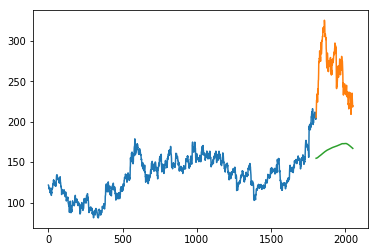

In [10]:
valid['predictions'] = 0
valid['predictions'] = pred
plt.plot(train['Close'])
plt.plot(valid[['Close','predictions']])

# Arima Model

In [12]:
from pyramid.arima import auto_arima

In [13]:
train_arima = train['Close']
valid_arima = train['Close']

model = auto_arima(train_arima,start_p = 1,start_q = 1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(train_arima)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=9978.899, BIC=9989.879, Fit time=3.095 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=9437.239, BIC=9459.199, Fit time=4.109 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=8713.902, BIC=8735.862, Fit time=13.100 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=8711.676, BIC=8739.126, Fit time=18.786 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=9437.240, BIC=9459.200, Fit time=3.336 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=8717.605, BIC=8750.545, Fit time=40.475 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=9980.642, BIC=9997.112, Fit time=0.979 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=8713.348, BIC=8751.778, Fit time=36.717 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 1, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

In [14]:
forecast = model.predict(n_periods = 248)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

In [15]:
rmse_arima=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
rmse_arima

48.879365846471465

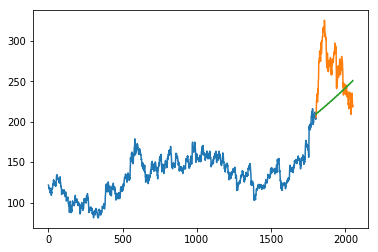

In [16]:
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forecast['Prediction'])

# LSTM

In [34]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout

datas = df.sort_index(ascending=True, axis=0)
new_data_lstm = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(datas)):
    new_data_lstm['Date'][i] = datas['Date'][i]
    new_data_lstm['Close'][i] = datas['Close'][i]

#setting index
new_data_lstm.index = new_data_lstm.Date
new_data_lstm.drop('Date', axis=1, inplace=True)

In [35]:
new_data_lstm.head()

,Close
Date,
2010-07-21,121.55
2010-07-22,120.9
2010-07-23,120.65
2010-07-26,117.6
2010-07-27,118.65


In [36]:
dataset = new_data_lstm.values
dataset,dataset.shape

(array([[121.55],
        [120.9],
        [120.65],
        ...,
        [223.25],
        [218.3],
        [219.8]], dtype=object), (2051, 1))

In [37]:
train_lstm = dataset[:1803,:]
valid_lstm = dataset[1803:,:]

scaled_data = sc.fit_transform(dataset)

x_train = []
y_train = []

for i in range(60,len(dataset)):
    x_train.append(scaled_data[i-60:i,:])
    y_train.append(scaled_data[i,0])
    
x_train,y_train = np.array(x_train),np.array(y_train)

C:\Users\Sudharshan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [38]:
#x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [56]:
model = Sequential()
model.add(LSTM(units = 50,return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(units = 50))
model.add(Dense(1))

model.compile(loss = 'mean_squared_error',optimizer = "Adam")
model.fit(x_train,y_train,epochs = 5,batch_size = 32,verbose = 2)

Epoch 1/5
 - 6s - loss: 0.0143
Epoch 2/5
 - 3s - loss: 9.8173e-04
Epoch 3/5
 - 3s - loss: 9.2810e-04
Epoch 4/5
 - 4s - loss: 8.5843e-04
Epoch 5/5
 - 3s - loss: 8.1610e-04


In [57]:
inputs = new_data_lstm[len(new_data_lstm) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = sc.inverse_transform(closing_price)

In [58]:
train_lstm = new_data_lstm[:1803]
valid_lstm = new_data_lstm[1803:]

valid_lstm['Predictions'] = 0
valid_lstm['Predictions'] = closing_price

C:\Users\Sudharshan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Sudharshan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [59]:
rmse_lstm = np.sqrt(np.mean(np.power((np.array(valid_lstm['Close'])-np.array(valid_lstm['Predictions'])),2)))
rmse_lstm

11.875728815999747

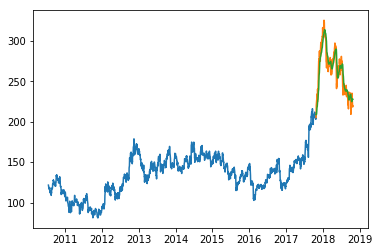

In [60]:
plt.plot(train_lstm['Close'])
plt.plot(valid_lstm[['Close','Predictions']])